Hello there. This notebook is meant to show you how you can use the `weak_sauce` code!

In [1]:
# import the package
import weak_sauce as ws

There are currently three main classes in `weak_sauce`: `Sources`, `Movers`, and `MoveableGrids`.

`Sources` represent images both in the sky and on the pixels. They have `vertices` which define the boundaries of each pixel. Each vertex has an $x$ and a $y$ coordinate. The units of the coordinates only matter when we start moving the source vertices and fluxes around due to other sources. Because we are in the weak sensor anomaly regime, the pixels never trade locations, so we order these vertices to easily define what pixels are where. We define pixel $p_{ij}$ as having the four vertices $(x_{i,j}, y_{i,j}), (x_{i + 1,j}, y_{i + 1,j}), (x_{i + 1,j + 1}, y_{i + 1, j + 1}), (x_{i, j + 1}, y_{i, j + 1})$, an associated flux $f_{ij}$ and centroid $r_{ij}$. The vertices, fluxes, and centroids are all represented as numpy arrays.

In [2]:
# Make a source.
# By default you only need to specify one number (num_x).
# This produces a square grid of num_x vertices with coordinates from 0 to num_x - 1
from weak_sauce.sources import Source
source = Source(3)
print('Vertices:\n', source.vertices)
print('Centroids:\n', source.centroids)
print('Fluxes:\n', source.fluxes)
# You can change these by specifying num_x, max_x, min_x, and corresponding *_y
print('Making new source. . . .')
source = Source(num_x=3, num_y=4, max_x=20, min_y=-2)
print('Vertices:\n', source.vertices)
print('Centroids:\n', source.centroids)
print('Fluxes:\n', source.fluxes)

# By default the flux is uniform zero. We can specifiy other flux functions. Let's
# make and use a simple 2d gaussian function with no covariance (rho=0).
print('Making gaussian source. . . .')
def gauss(centroids, mu=np.array([0, 0]), sigma=np.array([1., 1.])):
    return np.exp(-0.5 * np.sum(np.square((centroids - mu) / sigma), axis=2)) / \
           (2 * np.pi * np.prod(sigma))
source = Source(num_x=5, min_x=-2, max_x=2, flux_func=gauss)
print('Fluxes:\n', source.fluxes)

Vertices:
 [[[ 0.  0.]
  [ 0.  1.]
  [ 0.  2.]]

 [[ 1.  0.]
  [ 1.  1.]
  [ 1.  2.]]

 [[ 2.  0.]
  [ 2.  1.]
  [ 2.  2.]]]
Centroids:
 [[[ 0.5  0.5]
  [ 0.5  1.5]]

 [[ 1.5  0.5]
  [ 1.5  1.5]]]
Fluxes:
 [[ 0.  0.]
 [ 0.  0.]]
Making new source. . . .
Vertices:
 [[[  0.          -2.        ]
  [  0.          -0.33333333]
  [  0.           1.33333333]
  [  0.           3.        ]]

 [[ 10.          -2.        ]
  [ 10.          -0.33333333]
  [ 10.           1.33333333]
  [ 10.           3.        ]]

 [[ 20.          -2.        ]
  [ 20.          -0.33333333]
  [ 20.           1.33333333]
  [ 20.           3.        ]]]
Centroids:
 [[[  5.          -1.16666667]
  [  5.           0.5       ]
  [  5.           2.16666667]]

 [[ 15.          -1.16666667]
  [ 15.           0.5       ]
  [ 15.           2.16666667]]]
Fluxes:
 [[ 0.  0.  0.]
 [ 0.  0.  0.]]
Making gaussian source. . . .
Fluxes:
 [[ 0.02365627  0.05008032  0.01117443  0.0002628 ]
 [ 0.06430441  0.13613244  0.03037525  0.00

Sources also have convenient plotting functions. We can plot the vertices alone with plot_vertices, and the fluxes in pixel coordinates with plot_pixel_grid. We can combine the two together and plot plot_real_grid.

In [3]:
%matplotlib inline

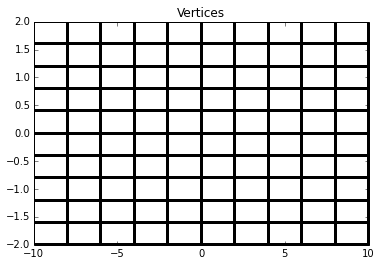

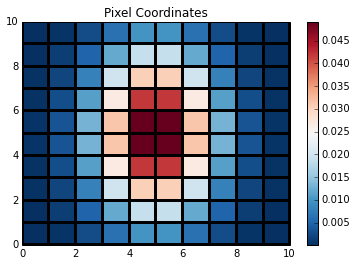

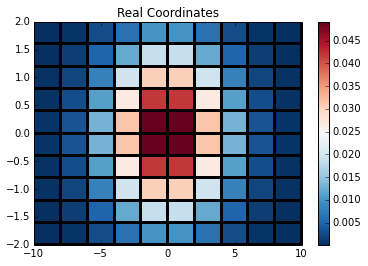

In [4]:
# Make a gaussian source.
source = Source(num_x=11, min_x=-10, max_x=10, 
                num_y=11, min_y=-2, max_y=2,
                flux_func=gauss,
                sigma=np.array([3, 1])
               )

# plot the vertices
fig, ax = source.plot_vertices()
ax.set_title('Vertices')

fig, ax = source.plot_pixel_grid()
ax.set_title('Pixel Coordinates')

fig, ax = source.plot_real_grid()
ax.set_title('Real Coordinates')

We can also evaluate the psf of a source. By default we evaluate moments in pixel coordinates.

In [5]:
source = Source(num_x=11, min_x=-10, max_x=10, 
                num_y=11, min_y=-2, max_y=2,
                flux_func=gauss,
                sigma=np.array([5, 1])
               )
moments_1 = source.evaluate_psf()


source = Source(num_x=11, min_x=-10, max_x=10, 
                num_y=11, min_y=-2, max_y=2,
                flux_func=gauss,
                mu=np.array([-4, 0]),
                sigma=np.array([2, 1])
               )
moments_2 = source.evaluate_psf()

moments = moments_1.append(moments_2, ignore_index=True)

# because we evaluated the first source in pixel coordinates, where our pixels are elongated,
# the image appears to be round
print(moments[['Mx', 'My', 'e0', 'e1', 'e2']])

    Mx        My        e0            e1            e2
0  4.5  4.500000  0.424773 -3.237410e-17 -3.061894e-18
1  4.5  2.500019  0.248978  1.757951e-01 -1.346005e-18


`Movers` move change the vertices and fluxes of sources according to fixed rules. They have `move_vertices` and `move_fluxes` methods, which return moved vertices and fluxes (respectively) when given input vertices and fluxes. The `move` method takes an input source object, moves its vertices and then (after moving the vertices) moves the fluxes. Calling a `mover` object accesses the `move` method.

Some movers are made to move only vertices around. Let's perturb our vertices by sampling from a two dimensional gaussian. By default these deposit flux according to a uniform illumination pattern. We plot below the fractional change relative to uniform illumination of a uniform grid.

In [6]:
from weak_sauce.movers import UniformIlluminationMover
def make_source():
    # return a simple grid
    source = Source(num_x=15, min_x=-40, max_x=40, 
                    num_y=15, min_y=-40, max_y=40)
    return source

def make_and_plot(mover, title=None):
    source = make_source()
    # calculate uniform illumination flux
    UniformIlluminationMover()(source)
    old_mean_flux = source.fluxes.mean()
    source.fluxes = 0 * old_mean_flux  # so that we have 0 flux initially
    mover(source)
    
    # make the fluxes relative to old mean flux
    source.fluxes = (source.fluxes - old_mean_flux) / old_mean_flux
    
    fig, ax = source.plot_vertices()
    ax.set_title('Vertices {0}'.format(title))

    fig, ax = source.plot_real_grid()
    ax.set_title('Real Coordinates {0}'.format(title))
    
    fig, ax = source.plot_pixel_grid()
    ax.set_title('Pixel Coordinates {0}'.format(title))

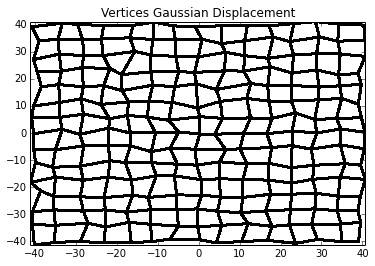

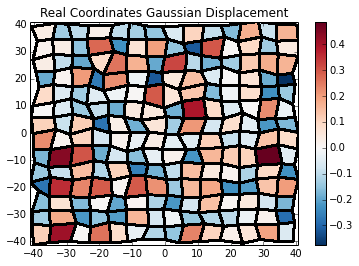

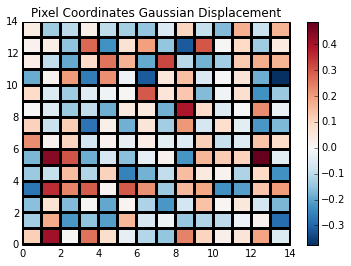

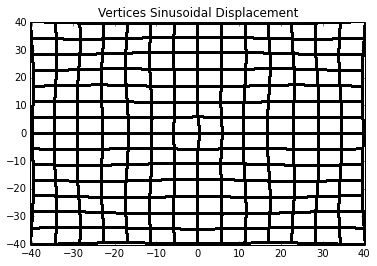

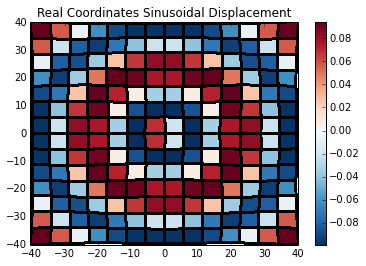

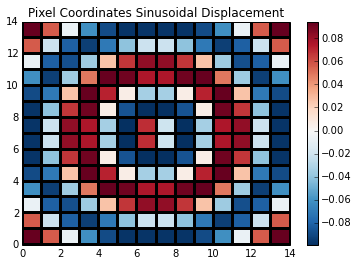

In [7]:
from weak_sauce.movers import UniformGaussianMover, UniformTreeringMover
mover = UniformGaussianMover(mu_x=0, mu_y=0, sigma_xx=0.5, sigma_yy=0.5, sigma_xy=0.2)
make_and_plot(mover, title='Gaussian Displacement')

mover = UniformTreeringMover(center=np.array([0, 0]), wavelength=30,
                              amplitude=0.5, phase=0.25)
make_and_plot(mover, title='Sinusoidal Displacement')

It is pretty easy to write your own vertices mover. We demonstrate that below:

In [8]:
class WhackoVerticesMover(UniformIlluminationMover):
    """
    We're going to twist about (0,0) as a function of radius
    """
    
    def __init__(self, phase=np.pi / 12, length=20, **kwargs):
        # run the init of uniformilluminationmover, which set the flux it deposited (in kwargs argument)
        super(WhackoVerticesMover, self).__init__(**kwargs)
        self.phase = phase
        self.length = length
    
    def move_vertices(self, vertices, fluxes, **kwargs):
        r = np.sqrt((np.sum(np.square(vertices), axis=2)))
        theta = np.arctan2(vertices[:, :, 1], vertices[:, :, 0])
        
        theta += self.phase * (r / self.length - 1)
        
        dvertices = np.dstack((r * np.cos(theta),
                               r * np.sin(theta))) - vertices
        return dvertices

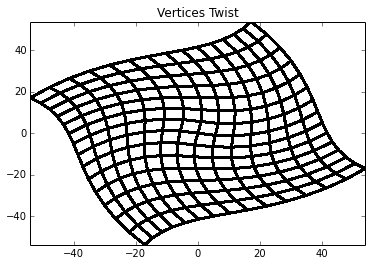

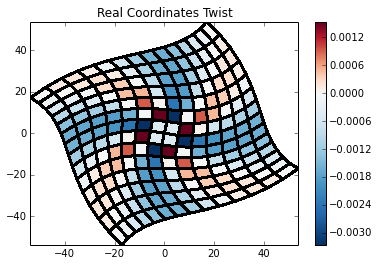

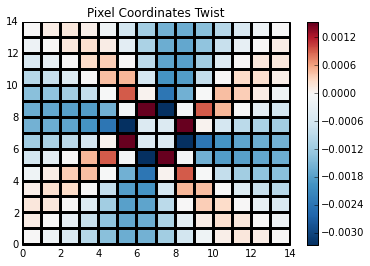

In [9]:
mover = WhackoVerticesMover(phase=np.pi / 12, length=20)
make_and_plot(mover, title='Twist')

Some movers are made to deposit flux from a source. `FixedIlluminationMovers` take an input source (assumed to be on a fixed grid) and move that illumination onto another source.

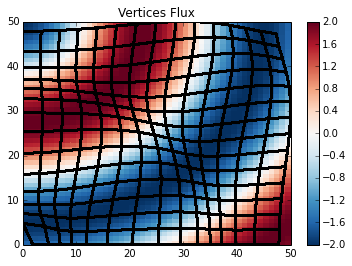

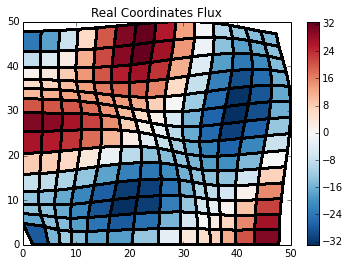

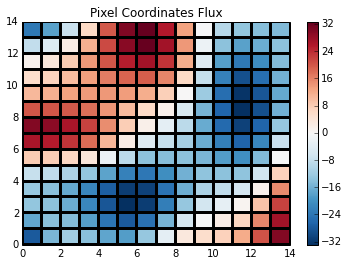

In [10]:
from weak_sauce.movers import FixedIlluminationMover, TreeringVerticesMover
# make an input source
def flux_xslope(centroids):
    return centroids[:, :, 0]

def flux_sin(centroids, center=np.array([0,50]), wavelength=45,
                 amplitude=2, phase=0.75):
    # convert vertices to radial coordinates about the center
    r = np.sqrt(np.sum(np.square(centroids - center), axis=2))

    r = amplitude * np.sin(2 * np.pi * (r / wavelength +
                                              phase))
    return r

stationary_source = Source(num_x=51, flux_func=flux_sin)
mover_flux = FixedIlluminationMover(stationary_source)

# let's set up our source using the WhackoVerticesMover
source = Source(num_x=15, min_x=0, max_x=51,
                num_y=15, min_y=0, max_y=51)  # pixel coordinates to match with stationary_souce
mover_vertices = TreeringVerticesMover(center=np.array([0, 0]), wavelength=30,
                                       amplitude=2, phase=0.25)

mover_vertices(source)
# adjust the vertices so that we're at (0,0)
source.vertices -= np.array([source.x_min, source.y_min])
source.vertices *= np.array([stationary_source.x_max, stationary_source.y_max]) / \
                   np.array([source.x_max, source.y_max])

title = 'Flux'
mover_flux(source)
fig, ax = stationary_source.plot(stationary_source.fluxes,
                                 stationary_source.vertices[:,:,0],
                                 stationary_source.vertices[:,:,1],
                                 pcolormesh_kwargs_in={'linewidths': 0})
fig, ax = source.plot_vertices(fig=fig, ax=ax)
ax.set_title('Vertices {0}'.format(title))

fig, ax = source.plot_real_grid()
ax.set_title('Real Coordinates {0}'.format(title))

fig, ax = source.plot_pixel_grid()
ax.set_title('Pixel Coordinates {0}'.format(title))

We aren't just limited to pixel coordinates. Let's work in some other basis.

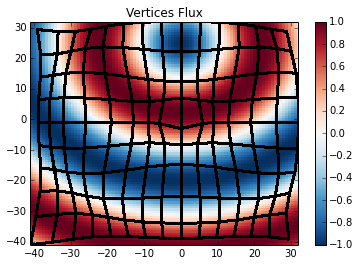

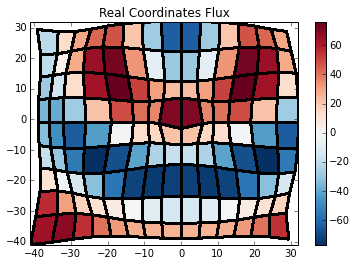

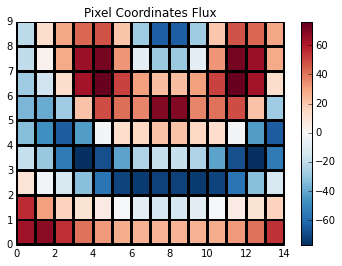

In [11]:
stationary_source = Source(num_x=101, min_x=-45, max_x=35,
                           num_y=101, min_y=-45, max_y=35,
                           flux_func=flux_sin,
                                    center=np.array([0,25]), wavelength=45,
                                    amplitude=1, phase=0.75)
mover_flux = FixedIlluminationMover(stationary_source)

# let's set up our source using the WhackoVerticesMover
source = Source(num_x=15, min_x=-40, max_x=30,
                num_y=10, min_y=-40, max_y=30)  # pixel coordinates to match with stationary_souce
mover_vertices = TreeringVerticesMover(center=np.array([0, 0]), wavelength=30,
                                       amplitude=2, phase=0.25)

mover_vertices(source)

title = 'Flux'
fig, ax = stationary_source.plot(stationary_source.fluxes,
                                 stationary_source.vertices[:,:,0],
                                 stationary_source.vertices[:,:,1],
                                 pcolormesh_kwargs_in={'linewidths': 0})
fig, ax = source.plot_vertices(fig=fig, ax=ax)
ax.set_title('Vertices {0}'.format(title))

mover_flux(source)
fig, ax = source.plot_real_grid()
ax.set_title('Real Coordinates {0}'.format(title))

fig, ax = source.plot_pixel_grid()
ax.set_title('Pixel Coordinates {0}'.format(title))

We could've made the above even easier by combining FixedIlluminationMover with WhackoVerticesMover:

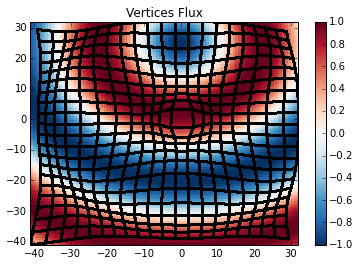

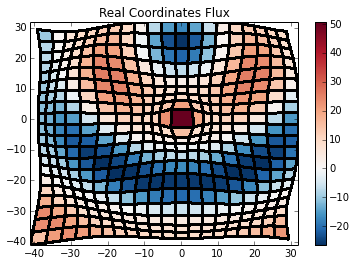

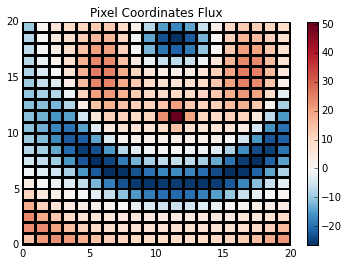

In [12]:
class FixedWhackoMover(TreeringVerticesMover, FixedIlluminationMover):
    def __init__(self, **kwargs):
        super(FixedWhackoMover, self).__init__(**kwargs)
stationary_source = Source(num_x=101, min_x=-45, max_x=35, 
                           num_y=101, min_y=-45, max_y=35,
                           flux_func=flux_sin,
                           center=np.array([0,25]), wavelength=45,
                                    amplitude=1, phase=0.75)
mover = FixedWhackoMover(stationary_source=stationary_source,
                         center=np.array([0, 0]), wavelength=30,
                                       amplitude=2, phase=0.25)

source = Source(num_x=21, min_x=-40, max_x=30,
                num_y=21, min_y=-40, max_y=30)#, num_y=10)  # pixel coordinates to match with stationary_souce

mover(source)

title = 'Flux'
fig, ax = stationary_source.plot(stationary_source.fluxes,
                                 stationary_source.vertices[:,:,0],
                                 stationary_source.vertices[:,:,1],
                                 pcolormesh_kwargs_in={'linewidths': 0})
fig, ax = source.plot_vertices(fig=fig, ax=ax)
ax.set_title('Vertices {0}'.format(title))

fig, ax = source.plot_real_grid()
ax.set_title('Real Coordinates {0}'.format(title))

fig, ax = source.plot_pixel_grid()
ax.set_title('Pixel Coordinates {0}'.format(title))

Let's check that the flux is being properly deposited. To do that we'll compare our depositor with a uniform flux against the exact answer.

Differences:
mean std median
-3.27075227572e-15 2.78650344867e-14 -5.3290705182e-15


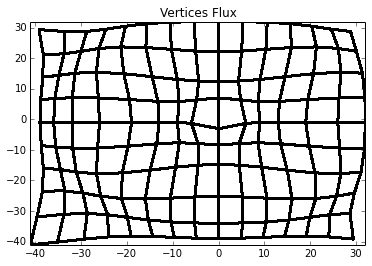

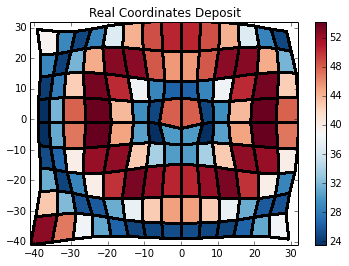

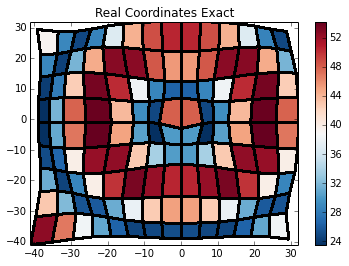

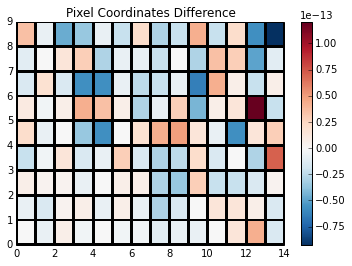

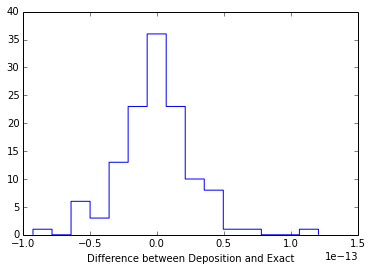

In [13]:
def flux_constant(centroids, flux=1):
    # area is roughly:
    x0, y0 = centroids[0, 0]
    x1, y1 = centroids[1, 1]
    area = (x1 - x0) * (y1 - y0)
    return np.ones(centroids.shape[:2]) * flux * area
stationary_source = Source(num_x=101, min_x=-45, max_x=35, 
                           num_y=101, min_y=-45, max_y=35,
                           flux_func=flux_constant)
treering_args = dict(center=np.array([0, 0]), wavelength=30, amplitude=2, phase=0.25)

mover_deposit = FixedWhackoMover(stationary_source=stationary_source, **treering_args)
mover_exact = UniformTreeringMover(**treering_args)

source_deposit = Source(num_x=15, min_x=-40, max_x=30,
                        num_y=10, min_y=-40, max_y=30)  # pixel coordinates to match with stationary_souce
source_exact = Source(num_x=15, min_x=-40, max_x=30,
                      num_y=10, min_y=-40, max_y=30)  # pixel coordinates to match with stationary_souce

mover_deposit(source_deposit)
mover_exact(source_exact)

title = 'Flux'
fig, ax = stationary_source.plot(stationary_source.fluxes,
                                 stationary_source.vertices[:,:,0],
                                 stationary_source.vertices[:,:,1],
                                 pcolormesh_kwargs_in={'linewidths': 0})
fig, ax = source_deposit.plot_vertices(fig=fig, ax=ax)
ax.set_title('Vertices {0}'.format(title))

fig, ax = source_deposit.plot_real_grid()
ax.set_title('Real Coordinates {0}'.format('Deposit'))
fig, ax = source_exact.plot_real_grid()
ax.set_title('Real Coordinates {0}'.format('Exact'))

flux_diff = source_deposit.fluxes - source_exact.fluxes
fig, ax = source_deposit.plot(flux_diff)
ax.set_title('Pixel Coordinates {0}'.format('Difference'))

plt.figure()
plt.hist(flux_diff.flatten(), histtype='step', bins=15)
plt.xlabel('Difference between Deposition and Exact')
print('Differences:')
print('mean', 'std', 'median')
print(flux_diff.mean(), flux_diff.std(), np.median(flux_diff))

# the only difference is in our flux coordinate

Let's repeat this for depositing a flux pattern onto a regular grid.

We test this by first depositing onto an irregular grid and then depositing back.

In [ ]:
from weak_sauce.r2d import skim

def flux_constant(centroids, flux=1):
    # area is roughly:
    x0, y0 = centroids[0, 0]
    x1, y1 = centroids[1, 1]
    area = (x1 - x0) * (y1 - y0)
    return np.ones(centroids.shape[:2]) * flux * area

num_x = 80
num_y = 45
source_exact = Source(num_x=num_x, min_x=0, max_x=num_x - 1, 
                      num_y=num_y, min_y=0, max_y=num_y - 1,
                      flux_func=flux_constant)
# stationary_source = Source(num_x=num_x, min_x=0, max_x=num_x - 1, 
#                            num_y=num_y, min_y=0, max_y=num_y - 1,
#                            flux_func=flux_constant)
source_exact = Source(num_x=num_x, min_x=-20, max_x=39, 
                      num_y=num_y, min_y=-5, max_y=42,
                      flux_func=flux_constant)
stationary_source = Source(num_x=num_x, min_x=-20, max_x=39, 
                      num_y=num_y, min_y=-5, max_y=42,
                      flux_func=flux_constant)

mover_deposit = FixedWhackoMover(stationary_source=stationary_source, **treering_args)

source_deposit = Source(num_x=11, min_x=11, max_x=30, 
                        num_y=17, min_y=15, max_y=38,)  # pixel coordinates to match with stationary_souce

mover_deposit(source_deposit)


# source_deposit = Source(num_x=31, min_x=10.5, max_x=30.5, 
#                            num_y=11, min_y=15, max_y=30.5,
#                            flux_func=flux_constant)

title = 'Flux'
fig, ax = source_deposit.plot(source_deposit.fluxes,
                                 source_deposit.vertices[:,:,0],
                                 source_deposit.vertices[:,:,1],
                                 pcolormesh_kwargs_in={'linewidths': 0})
fig, ax = source_deposit.plot_vertices(fig=fig, ax=ax)
ax.set_title('Pre-Redeposit Vertices {0}'.format(title))

dfluxes = mover_deposit.skim_fluxes(source_deposit.vertices, source_deposit.fluxes)
stationary_source.fluxes = dfluxes
# stationary_source.fluxes -= 1

title = 'Flux'
fig, ax = stationary_source.plot(stationary_source.fluxes,
                                 stationary_source.vertices[:,:,0],
                                 stationary_source.vertices[:,:,1],
                                 pcolormesh_kwargs_in={'linewidths': 0})
fig, ax = source_deposit.plot_vertices(fig=fig, ax=ax)
ax.set_title('Vertices {0}'.format(title))

fig, ax = stationary_source.plot_real_grid()
ax.set_title('Real Coordinates {0}'.format('Stationary'))
fig, ax = source_exact.plot_real_grid()
ax.set_title('Real Coordinates {0}'.format('Exact'))

flux_diff = stationary_source.fluxes - source_exact.fluxes
fig, ax = source_deposit.plot(flux_diff)
ax.set_title('Pixel Coordinates {0}'.format('Difference'))

plt.figure()
plt.hist(flux_diff.flatten(), histtype='step', bins=15)
plt.xlabel('Difference between Deposition and Exact')
print('Differences:')
print('mean', 'std', 'median')
print(flux_diff.mean(), flux_diff.std(), np.median(flux_diff))

# the only difference is in our flux coordinate

(4, 5)
(4, 3)
((13, 16), (9, 11))
((40, 68), (17, 39))
(4, 3)
[[ 53.36391822  26.85258688]
 [ 56.04441754  26.82602846]
 [ 55.92130033  28.16158533]
 [ 53.34114585  28.26884248]]
[[ 0.36391822  0.85258688]
 [ 3.04441754  0.82602846]
 [ 2.92130033  2.16158533]
 [ 0.34114585  2.26884248]]
(29, 23)


(5, 5)
(4, 3)
((15, 18), (9, 11))
((40, 68), (17, 39))
(4, 3)
[[ 56.04441754  26.82602846]
 [ 58.57883275  26.70280749]
 [ 58.35764356  27.96647708]
 [ 55.92130033  28.16158533]]
[[ 1.04441754  0.82602846]
 [ 3.57883275  0.70280749]
 [ 3.35764356  1.96647708]
 [ 0.92130033  2.16158533]]
(29, 23)


Differences:
mean std median
-0.685772657385 0.27148260848 -0.797756041427


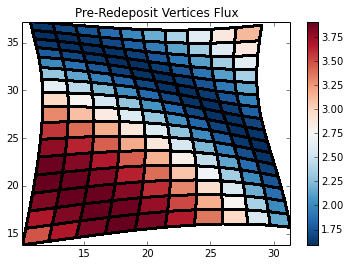

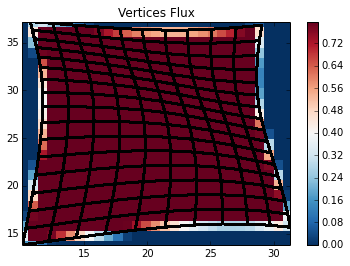

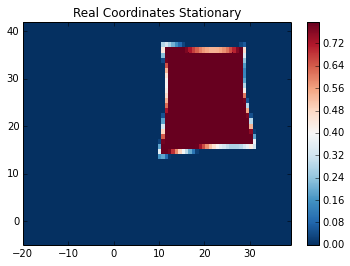

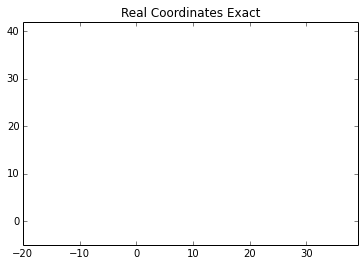

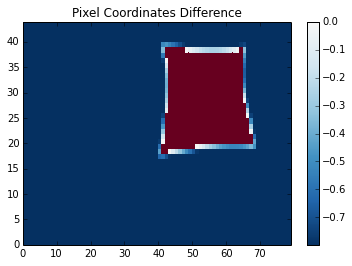

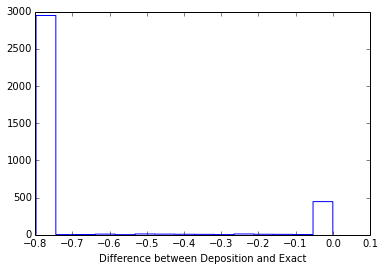

In [64]:
from weak_sauce.r2d import skim

def flux_constant(centroids, flux=1):
    # area is roughly:
    x0, y0 = centroids[0, 0]
    x1, y1 = centroids[1, 1]
    area = (x1 - x0) * (y1 - y0)
    return np.ones(centroids.shape[:2]) * flux * area

num_x = 80
num_y = 45
source_exact = Source(num_x=num_x, min_x=0, max_x=num_x - 1, 
                      num_y=num_y, min_y=0, max_y=num_y - 1,
                      flux_func=flux_constant)
# stationary_source = Source(num_x=num_x, min_x=0, max_x=num_x - 1, 
#                            num_y=num_y, min_y=0, max_y=num_y - 1,
#                            flux_func=flux_constant)
source_exact = Source(num_x=num_x, min_x=-20, max_x=39, 
                      num_y=num_y, min_y=-5, max_y=42,
                      flux_func=flux_constant)
stationary_source = Source(num_x=num_x, min_x=-20, max_x=39, 
                      num_y=num_y, min_y=-5, max_y=42,
                      flux_func=flux_constant)

mover_deposit = FixedWhackoMover(stationary_source=stationary_source, **treering_args)

source_deposit = Source(num_x=11, min_x=11, max_x=30, 
                        num_y=17, min_y=15, max_y=38,)  # pixel coordinates to match with stationary_souce

mover_deposit(source_deposit)


# source_deposit = Source(num_x=31, min_x=10.5, max_x=30.5, 
#                            num_y=11, min_y=15, max_y=30.5,
#                            flux_func=flux_constant)

title = 'Flux'
fig, ax = source_deposit.plot(source_deposit.fluxes,
                                 source_deposit.vertices[:,:,0],
                                 source_deposit.vertices[:,:,1],
                                 pcolormesh_kwargs_in={'linewidths': 0})
fig, ax = source_deposit.plot_vertices(fig=fig, ax=ax)
ax.set_title('Pre-Redeposit Vertices {0}'.format(title))

# move back
verts = source_deposit.vertices.copy()
# convert verts into pixel coordinates
verts = (verts - stationary_source.r0) / (stationary_source.r1 - stationary_source.r0)

dfluxes = skim(source_deposit.fluxes, verts)
stationary_source.fluxes *= 0
# add fluxes at the right locations
x = verts[:, :, 0]
y = verts[:, :, 1]
xmax_all = int(x.max())
xmin_all = int(x.min())
ymax_all = int(y.max())
ymin_all = int(y.min())
    
stationary_source.fluxes[xmin_all:xmax_all+1, ymin_all:ymax_all+1] = dfluxes
# stationary_source.fluxes -= 1

title = 'Flux'
fig, ax = stationary_source.plot(stationary_source.fluxes,
                                 stationary_source.vertices[:,:,0],
                                 stationary_source.vertices[:,:,1],
                                 pcolormesh_kwargs_in={'linewidths': 0})
fig, ax = source_deposit.plot_vertices(fig=fig, ax=ax)
ax.set_title('Vertices {0}'.format(title))

fig, ax = stationary_source.plot_real_grid()
ax.set_title('Real Coordinates {0}'.format('Stationary'))
fig, ax = source_exact.plot_real_grid()
ax.set_title('Real Coordinates {0}'.format('Exact'))

flux_diff = stationary_source.fluxes - source_exact.fluxes
fig, ax = source_deposit.plot(flux_diff)
ax.set_title('Pixel Coordinates {0}'.format('Difference'))

plt.figure()
plt.hist(flux_diff.flatten(), histtype='step', bins=15)
plt.xlabel('Difference between Deposition and Exact')
print('Differences:')
print('mean', 'std', 'median')
print(flux_diff.mean(), flux_diff.std(), np.median(flux_diff))

# the only difference is in our flux coordinate

`MoveableGrids` are the meat of this package. (Or at least they will be once we write some more code.)

It has all the functions outlined above in one namespace, and will probably have more later too.

Warning! plot_naieve_grid deprecated! Use plot_pixel_grid!


,Mx,Mxx,Mxy,My,Myy,a4,delta1,delta2,e0,e0prime,...,whisker,x2,x2y,x3,xy,xy2,y2,y3,zeta1,zeta2
0,7.057861,2.924557,0.000004,9.500001,29.194663,-0.241404,-0.749846,3.333221e-07,1.170747,1.844358,...,3.624231,1.46228,0.000004,0.778319,0.000002,12.958141,14.597344,-0.000006,0.270375,-5.518118e-08


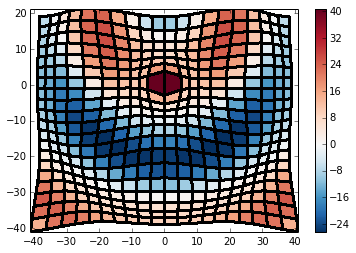

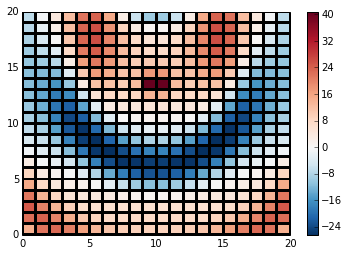

In [15]:
from weak_sauce.grid import MoveableGrid

stationary_source = Source(num_x=201, min_x=-50, max_x=50, flux_func=flux_sin,
                           center=np.array([0,25]), wavelength=45,
                                    amplitude=1, phase=0.75)
mover = FixedWhackoMover(stationary_source=stationary_source,
                         center=np.array([0, 0]), wavelength=30,
                                       amplitude=2, phase=0.25)

source = Source(num_x=21, min_x=-40, max_x=40)  # pixel coordinates to match with stationary_souce

mg = MoveableGrid(source, mover)
mg.step()
mg.plot_real_grid()
mg.plot_pixel_grid()

mg.evaluate_psf()

Let's test fitting flux data

In [16]:
from weak_sauce.fit_flat import FlatFitter
mover_gen = UniformTreeringMover(center=np.array([0, 0]), wavelength=30,
                                 amplitude=0.5, phase=0.25,
                                 flux=1)
source_gen = make_source()
mover_gen(source_gen)
fitter = FlatFitter(source_gen.fluxes, luminosity=1)
source_gen.plot_real_grid()

source = make_source()
# source.plot_real_grid()
for i in xrange(100):
    fitter(source, step_size=1e-3)
source.plot_real_grid()

# source_gen.plot_pixel_grid()
# source.plot_pixel_grid()

print(fitter.luminosity)
print(fitter.lnlike(source.vertices, source.fluxes))
print(source_gen.fluxes.sum(), source.fluxes.sum())

flux_diff = np.abs(source.fluxes - source_gen.fluxes)
fig, ax = source.plot(flux_diff)
ax.set_title('Model - Data Fluxes')

cent_diff = np.sqrt(np.sum(np.square(source.centroids - source_gen.centroids), axis=2))
fig, ax = source.plot(cent_diff, source.vertices[:,:,0], source.vertices[:,:,1])
ax.set_title('RMS Displacement of Centroids')


TypeError: __init__() takes at least 3 arguments (3 given)

In [ ]:
plt.imshow(flux_diff)

flux_diff

Let's test fitting data. We'll make multiple movers and move the source multiple times to initalize.

TODO: Make the movers able to add to each other. That would be cool.

In [ ]:
class UniformDecayingSinusoidal(UniformIlluminationMover):
    def __init__(self, center=np.array([0,0]), wavelength=10,
                 amplitude=1, phase=0, decay_length=10, **kwargs):
        super(UniformDecayingSinusoidal, self).__init__(**kwargs)
        self.center = center
        self.wavelength = wavelength
        self.amplitude = amplitude
        self.phase = phase
        self.decay_length = decay_length

    def move_vertices(self, vertices, fluxes, **kwargs):
        # convert vertices to radial coordinates about the center
        r = np.sqrt(np.sum(np.square(vertices - self.center), axis=2))
        theta = np.arctan2(vertices[:, :, 1] - self.center[1],
                           vertices[:, :, 0] - self.center[0])

        # displace along radius
        dr = self.amplitude * np.sin(2 * np.pi * (r / self.wavelength +
                                                  self.phase))
        # decay the dr
        dr *= np.exp(-r / self.decay_length)
        r += dr

        vertices = np.dstack((r * np.cos(theta),
                              r * np.sin(theta))) + self.center
        return vertices

In [ ]:
num_x_gen = 100
source_gen = Source(num_x=num_x_gen, num_y=2 * num_x_gen,
                    max_x=num_x_gen - 1, min_x=0,
                    max_y=2 * num_x_gen - 2, min_y=0)


mover_gen = UniformGaussianMover(mu_x=0, mu_y=0, sigma_xx=0.005, sigma_yy=0.015, sigma_xy=0.0)
mover_gen(source_gen)

mover_gen = UniformDecayingSinusoidal(center=np.array([num_x_gen / 4., num_x_gen / 4.]),
                                      wavelength=5, decay_length=75,
                                      amplitude=0.5, phase=1,
                                      flux=1)
mover_gen(source_gen)

mover_gen = UniformDecayingSinusoidal(center=np.array([num_x_gen * 3 / 4., num_x_gen * 5 / 4.]),
                                      wavelength=10, decay_length=50,
                                      amplitude=1., phase=0.5,
                                      flux=1)
mover_gen(source_gen)

mover_gen = UniformDecayingSinusoidal(center=np.array([num_x_gen * 2 / 5., num_x_gen * 7 / 4.]),
                                      wavelength=20, decay_length=70,
                                      amplitude=0.5, phase=0.5,
                                      flux=1)
mover_gen(source_gen)

mover_gen = UniformDecayingSinusoidal(center=np.array([num_x_gen * 2 / 5., num_x_gen * 3 / 4.]),
                                      wavelength=10, decay_length=100,
                                      amplitude=0.75, phase=0.5,
                                      flux=1)
mover_gen(source_gen)

mover_gen = UniformDecayingSinusoidal(center=np.array([num_x_gen * 4 / 5., num_x_gen * 1 / 4.]),
                                      wavelength=10, decay_length=20,
                                      amplitude=1, phase=-0.5,
                                      flux=1)
mover_gen(source_gen)

fig, axs = plt.subplots(figsize=(12,5), ncols=2)
ax = axs[0]
source_gen.plot(source_gen.fluxes,
                source_gen.vertices[:,:,0], source_gen.vertices[:,:,1],
                pcolormesh_kwargs_in={'linewidths':0},
                fig=fig, ax=ax)
ax.set_title('Real Coordinates')
ax = axs[1]
source_gen.plot(source_gen.fluxes,
                #source_gen.vertices[:,:,0], source_gen.vertices[:,:,1],
                pcolormesh_kwargs_in={'linewidths':0},
                fig=fig, ax=ax)
ax.set_title('Pixel Coordinates')

In [ ]:
import matplotlib.pyplot as plt
from weak_sauce.shifted_cmap import shiftedColorMap, wrappedColorMap, angleColorMap

In [ ]:
source = Source(num_x=num_x_gen, num_y=2 * num_x_gen,
                    max_x=num_x_gen - 1, min_x=0,
                    max_y=2 * num_x_gen - 2, min_y=0)
vertices_best = np.copy(source.vertices)
fluxes_best = np.copy(source.fluxes)
centroids_best = np.copy(source.centroids)

fitter = FlatFitter(source_gen.fluxes, luminosity=1)
# source.plot_real_grid()

for step_size in [1e-2, 1e-3, 1e-4]:
    lnlike_best = -10000
    lnlike_old = -10000
    lnlike = -10000
    cutoff = 0
    for i in xrange(2200):
        if cutoff > 1:
            print('Cutting off at', i, cutoff, step_size)
            print('Resetting to old!')
            source.vertices = np.copy(vertices_best)
            source.fluxes = np.copy(fluxes_best)
            source.centroids = np.copy(centroids_best)
            break
        fitter(source, step_size=step_size)
        lnlike, lnlike_old = fitter.lnlike(source.vertices, source.fluxes), lnlike
        if lnlike > lnlike_best:
            vertices_best = np.copy(source.vertices)
            fluxes_best = np.copy(source.fluxes)
            centroids_best = np.copy(source.centroids)
            lnlike_best = lnlike
        if lnlike < lnlike_old:
            cutoff += 1
        
fig, axs = plt.subplots(figsize=(5*2,5*4), ncols=2, nrows=4)

ax = axs[0,0]
ZZ = source_gen.fluxes
XX = None
# figure out shifting the colormap
b = np.max(ZZ)
a = np.min(ZZ)
c = 0
midpoint = (c - a) / (b - a)
vmin = a
vmax = b
if np.all(ZZ == np.median(ZZ)):
    cmap = plt.cm.gray_r
    # this sets the faces transparent
    vmin = np.median(ZZ) + 1
    vmax = np.median(ZZ) + 2
    cmap.set_under(alpha=0)
elif midpoint <= 0:
    cmap = plt.cm.RdBu_r#plt.cm.Reds
else:
    cmap = shiftedColorMap(plt.cm.RdBu_r, midpoint=midpoint)

if type(XX) == type(None):
    # make an XX and YY grid
    num_x, num_y = ZZ.shape
    XX, YY = np.meshgrid(np.linspace(0, num_x, num_x + 1, endpoint=True),
                         np.linspace(0, num_y, num_y + 1, endpoint=True),
                         indexing='ij')
IM = ax.pcolormesh(XX, YY, ZZ, cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(IM, ax=ax)

ax.set_xlim(XX.min(), XX.max())
ax.set_ylim(YY.min(), YY.max())
ax.set_title('Input')

ax = axs[0,1]
ZZ = source.fluxes
XX = None

if type(XX) == type(None):
    # make an XX and YY grid
    num_x, num_y = ZZ.shape
    XX, YY = np.meshgrid(np.linspace(0, num_x, num_x + 1, endpoint=True),
                         np.linspace(0, num_y, num_y + 1, endpoint=True),
                         indexing='ij')
IM = ax.pcolormesh(XX, YY, ZZ, cmap=cmap, vmin=vmin, vmax=vmax)
if not np.all(ZZ == np.median(ZZ)):
    # don't plot a colorbar if we don't have any values!
    fig.colorbar(IM, ax=ax)

ax.set_xlim(XX.min(), XX.max())
ax.set_ylim(YY.min(), YY.max())
ax.set_title('Fit')



# source_gen.plot_pixel_grid()
# source.plot_pixel_grid()

print(fitter.luminosity)
print(fitter.lnlike(source.vertices, source.fluxes))
print(source_gen.fluxes.sum(), source.fluxes.sum())

ax = axs[1,0]
flux_diff = source.fluxes - source_gen.fluxes
fig, ax = source.plot(flux_diff,
                      fig=fig, ax=ax,
                      pcolormesh_kwargs_in={'linewidths':0},)
ax.set_title('Model - Data Fluxes')

flux_diff = source.fluxes / source_gen.fluxes
ax = axs[1, 1]
fig, ax = source.plot(flux_diff,
                      fig=fig, ax=ax,
                      pcolormesh_kwargs_in={'linewidths':0},)
ax.set_title('Model / Data Fluxes')

cent_diff = np.sqrt(np.sum(np.square(source.centroids - source_gen.centroids), axis=2))
ax = axs[2, 0]
fig, ax = source.plot(cent_diff, #source.vertices[:,:,0], source.vertices[:,:,1],
                      fig=fig, ax=ax,
                      pcolormesh_kwargs_in={'linewidths':0},)
ax.set_title('Magnitude of Error of Centroids')

cent_rot = np.arctan2(source.centroids[:, :, 1] - source_gen.centroids[:, :, 1],
                      source.centroids[:, :, 0] - source_gen.centroids[:, :, 0]) * 180 / np.pi
ax = axs[2, 1]

ZZ = cent_rot
cmap = angleColorMap(plt.cm.RdBu, plt.cm.jet)
num_x, num_y = ZZ.shape
XX, YY = np.meshgrid(np.linspace(0, num_x, num_x + 1, endpoint=True),
                     np.linspace(0, num_y, num_y + 1, endpoint=True),
                     indexing='ij')
IM = ax.pcolormesh(XX, YY, ZZ, cmap=cmap, vmin=-180, vmax=180)
fig.colorbar(IM, ax=ax)
ax.set_title('Direction of Error of Centroids')

cent_diff = (source.centroids - source_gen.centroids)
ax = axs[3, 0]
fig, ax = source.plot(cent_diff[:,:,0], #source.vertices[:,:,0], source.vertices[:,:,1],
                      fig=fig, ax=ax,
                      pcolormesh_kwargs_in={'linewidths':0},)
ax.set_title('X Error in Centroids')
ax = axs[3, 1]
fig, ax = source.plot(cent_diff[:,:,1], #source.vertices[:,:,0], source.vertices[:,:,1],
                      fig=fig, ax=ax,
                      pcolormesh_kwargs_in={'linewidths':0},)
ax.set_title('Y Error in Centroids')

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))
fig, ax = source.plot(source.fluxes - source_gen.fluxes,
                      fig=fig, ax=ax,
                      pcolormesh_kwargs_in={'linewidths':0},)
ax.set_title('Fit - Input')

fig, ax = plt.subplots(figsize=(9,7))
fig, ax = source.plot(source.fluxes,
                      fig=fig, ax=ax,
                      pcolormesh_kwargs_in={'linewidths':0},)
ax.set_title('Fit')

fig, ax = plt.subplots(figsize=(9,7))
fig, ax = source.plot(source_gen.fluxes,
                      fig=fig, ax=ax,
                      pcolormesh_kwargs_in={'linewidths':0},)
ax.set_title('Input')

fig, ax = plt.subplots(figsize=(9,7))
fig, ax = source.plot(vert_diff[:,:,0],
                      fig=fig, ax=ax,
                      pcolormesh_kwargs_in={'linewidths':0},)
ax.set_title('X vertex difference')

fig, ax = plt.subplots(figsize=(9,7))
fig, ax = source.plot(vert_diff[:,:,1],
                      fig=fig, ax=ax,
                      pcolormesh_kwargs_in={'linewidths':0},)
ax.set_title('Y vertex difference')

cutoff = 20
fig, ax = plt.subplots(figsize=(9,7))
fig, ax = source.plot(vert_diff[cutoff:-cutoff, cutoff:-cutoff, 0],
                      fig=fig, ax=ax,
                      pcolormesh_kwargs_in={'linewidths':0},)
ax.set_title('X vertex difference with {0} cut off'.format(cutoff))

fig, ax = plt.subplots(figsize=(9,7))
fig, ax = source.plot(vert_diff[cutoff:-cutoff, cutoff:-cutoff, 1],
                      fig=fig, ax=ax,
                      pcolormesh_kwargs_in={'linewidths':0},)
ax.set_title('Y vertex difference with {0} cut off'.format(cutoff))

In [ ]:
np.std(((source.vertices - source_gen.vertices))[:,:,1])

In [ ]:
from weak_sauce.data_tools import makeCorr

_ = makeCorr((source.vertices - source_gen.vertices)[:,:,0],
             rescale_cmap=True, N=11)
plt.title('Correlation in X Vertex Residual')
_ = makeCorr((source.vertices - source_gen.vertices)[:,:,1],
             rescale_cmap=True, N=11)
plt.title('Correlation in Y Vertex Residual')
_ = makeCorr(source.fluxes - source_gen.fluxes,
             rescale_cmap=True, N=11)
plt.title('Correlation in Flux Residual')

In [ ]:
# checker of vertices
vert_diff = source.vertices - source_gen.vertices
plt.figure()
plt.hist([vert_diff[:,:,0].flatten(), vert_diff[:,:,1].flatten()], bins=150, histtype='step');
plt.xlabel('Fit Vertex - Input Vertex Coordinate')

In [ ]:
plt.hist2d(source.vertices[:,:,0].flatten(), (source.vertices[:,:,0] - source_gen.vertices[:,:,0]).flatten(), bins=100);
plt.colorbar();

In [ ]:
plt.scatter(source.vertices[:,:,0].flatten(), (source.vertices[:,:,0] - source_gen.vertices[:,:,0]).flatten())

In [ ]:
print(source.vertices.shape)

In [ ]:
vertices = np.dstack(np.meshgrid(
    np.linspace(0, 99, 100, endpoint=True),
    np.linspace(0, 199, 200, endpoint=True),
    indexing='ij'))

In [ ]:
vertices.shape

In [ ]:
plt.hist2d((source.vertices[:,:,1] - vertices[:,:,1]).flatten()
           - (source.vertices[:,:,1] - vertices[:,:,1]).flatten().mean(),
           (source_gen.vertices[:,:,1] - vertices[:,:,1]).flatten()
           - (source_gen.vertices[:,:,1] - vertices[:,:,1]).flatten().mean(),
           bins=100, cmin=1);
plt.colorbar();
plt.xlabel('Location of Y model vertex to pixel coordinate')
plt.ylabel('Location of Y fit vertex to pixel coordinate')

In [ ]:
plt.hist2d((source.vertices[:,:,0] - vertices[:,:,0]).flatten()
           - (source.vertices[:,:,0] - vertices[:,:,0]).flatten().mean(),
           (source_gen.vertices[:,:,0] - vertices[:,:,0]).flatten()
           - (source_gen.vertices[:,:,0] - vertices[:,:,0]).flatten().mean(),
           bins=100, cmin=1);
plt.colorbar();
plt.xlabel('Location of X model vertex to pixel coordinate')
plt.ylabel('Location of X fit vertex to pixel coordinate')

In [ ]:
print(np.mean(np.abs(vert_diff[20:-20,20:-20,0]).flatten(), axis=0))

In [ ]:
plt.figure(figsize=(12,9))
plt.imshow(vert_diff[:,:,0].T)
plt.colorbar()
plt.title('X vertex difference')

In [ ]:
plt.figure(figsize=(12,9))
plt.imshow(vert_diff[:,:,1].T)
plt.colorbar()
plt.title('Y vertex difference')